# Análise de Séries Temporais de Temperatura (Médias Móveis e Autocorrelação)

---

Este notebook realiza uma análise de séries temporais focada na temperatura, utilizando dados climáticos de estações localizadas no Brasil. O afunilamennto em estações específicas é feito de maneira proposital para conseguirmos vizualizar melhor o comportamento dos dados do dataset. Aqui focamos em análisar a temperatura média das estações. 


## Instalando dependências

Os pacotes pyarrow e fastparquet é utilizado para facilitar e otimizar o carregamento do dataset em memória.
o dataset em formato CSV sendo carregado inteiro na memória RAM pode acabar sendo extremamente lento e inviável.

In [5]:
!pip install pandas
!pip install matplotlib
!pip install pyarrow
!pip install fastparquet
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Criando o arquivo Parquet

---

Aqui é realizado a conversão do dataset em formato CSV para formato PARQUET, o parquet é um formato binário
mais leve que irá facilitar o carregamento do dataset em memória nos diferentes notebooks.

In [ ]:
import pandas as pd

dtype_mapping = {
    "station": "object",
    "year": "int16",
    "month": "int8",
    "day": "int8",
    "element": "object",
    "value": "int16",
    "mflag": "object",
    "qflag": "object",
    "sflag": "object",
}

print("Iniciando carregamento do CSV (com dtypes) para conversão...")
data = pd.read_csv(
    "../data/dataset/data_final.csv",
    sep=";",
    dtype=dtype_mapping
)

data["date"] = pd.to_datetime(
    data[["year", "month", "day"]],
    errors="coerce"
)

data = data[(data["value"] != -9999) & (data["value"] < 2000)].copy()
data = data.dropna(subset=["date"]).copy()

parquet_path = "../data/dataset/data_final_optimized.parquet"
data.to_parquet(parquet_path, index=False)

print(f"✅ Dataset otimizado salvo em Parquet: {parquet_path}")
print(data.info(memory_usage='deep'))

### Carregando o PARQUET gerado

In [ ]:
import pandas as pd

parquet_path = "../data/dataset/data_final_optimized.parquet"

data = pd.read_parquet(parquet_path)
print(data)
print("✅Carregamento concluído.")


               station  year  month  day element  value mflag qflag sflag  \
0          AE000041196  1944      3   20    TMAX    380                 I   
1          AE000041196  1944      3   21    TMAX    346                 I   
2          AE000041196  1944      3   22    TMAX    319                 I   
3          AE000041196  1944      3   23    TMAX    302                 I   
4          AE000041196  1944      3   24    TMAX    296                 I   
...                ...   ...    ...  ...     ...    ...   ...   ...   ...   
101697729  ZI000067983  2025      8   19    TAVG    167     H           S   
101697730  ZI000067983  2025      8   20    TAVG    196     H           S   
101697731  ZI000067983  2025      8   21    TAVG    208     H           S   
101697732  ZI000067983  2025      8   22    TAVG    240     H           S   
101697733  ZI000067983  2025      8   23    TAVG    233     H           S   

                date  
0         1944-03-20  
1         1944-03-21  
2     

### Filtrando as estações Brasileiras

---

Aqui é de interesse análisar somente os dados que realmente iremos utilizar para as análises.
No caso os dados de temperatura por estação

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

br_stations = [
    "BRM00083264",
    "BRM00083064",
    "BRM00082425",
    "BRM00082410",
    "BRM00082331"
]

station_data = data[data["station"].isin(br_stations)].copy()
data_filtrada = station_data[station_data["element"].isin(["TMAX","TMIN"])]

data_filtrada["temperature"] = data_filtrada["value"] * 0.1
print(data_filtrada)

C:\Users\felip\AppData\Local\Temp\ipykernel_17036\74867102.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrada["temperature"] = data_filtrada["value"] * 0.1


              station  year  month  day element  value mflag qflag sflag  \
11364365  BRM00082331  1973      2   21    TMIN    240                 S   
11364368  BRM00082331  1974      6   21    TMAX    320                 S   
11364369  BRM00082331  1974      6   22    TMAX    320                 S   
11364370  BRM00082331  1974      6   28    TMAX    320                 S   
11364371  BRM00082331  1974      6   21    TMIN    230                 S   
...               ...   ...    ...  ...     ...    ...   ...   ...   ...   
11371900  BRM00083264  1992      6    9    TMAX    335                 S   
11371901  BRM00083264  1992      6    9    TMIN    186                 S   
11371904  BRM00083264  1992      8   19    TMAX    321                 S   
11371905  BRM00083264  1992      8   19    TMIN    197                 S   
11371906  BRM00083264  1992      8   27    TMIN    197                 S   

               date  temperature  
11364365 1973-02-21         24.0  
11364368 1974-06-

## Média de temperatura das estações localizadas no Brasil
---
Decidimos trabalhar com uma série temporal dividida por ano, mês e dia, conseguimos notar a volátilidade das médias de temperatura
ao longo da série, não seguindo um padrão claro.

Importante notar também a dificuldade de análisar os dados dia a dia ao longo da série, uma vez que estes dados não seguem um padrão claro

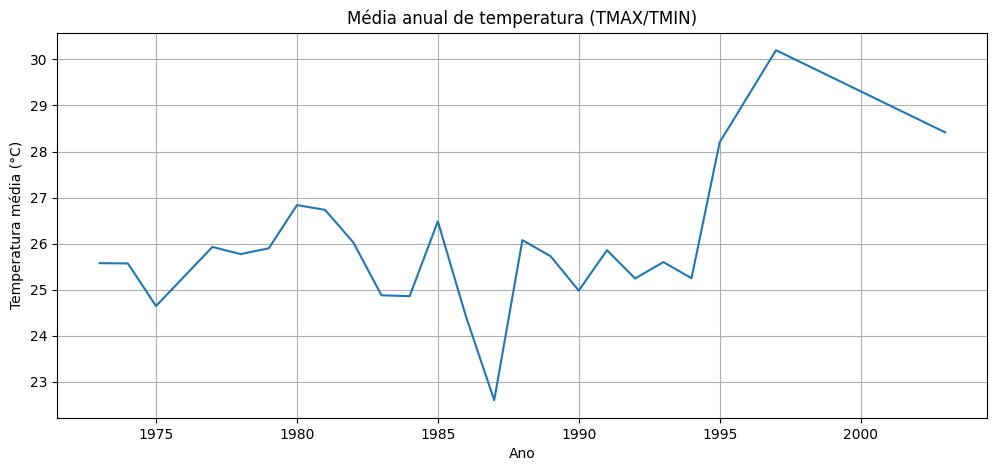

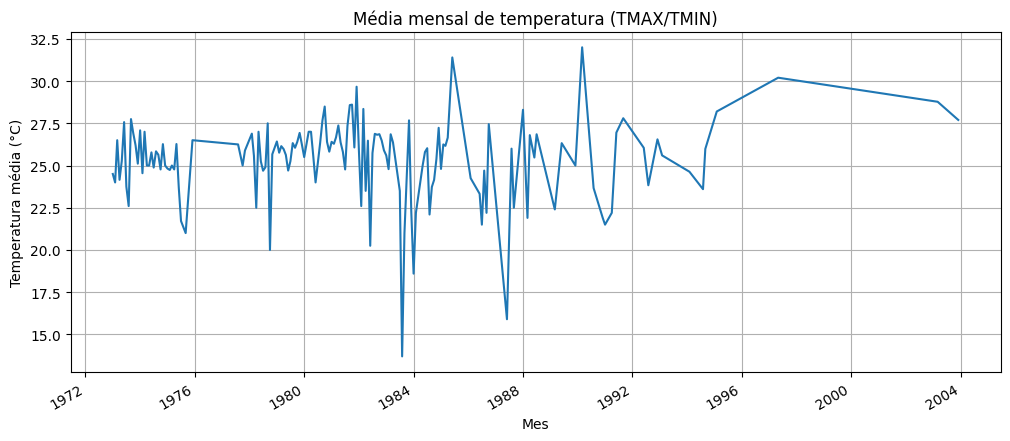

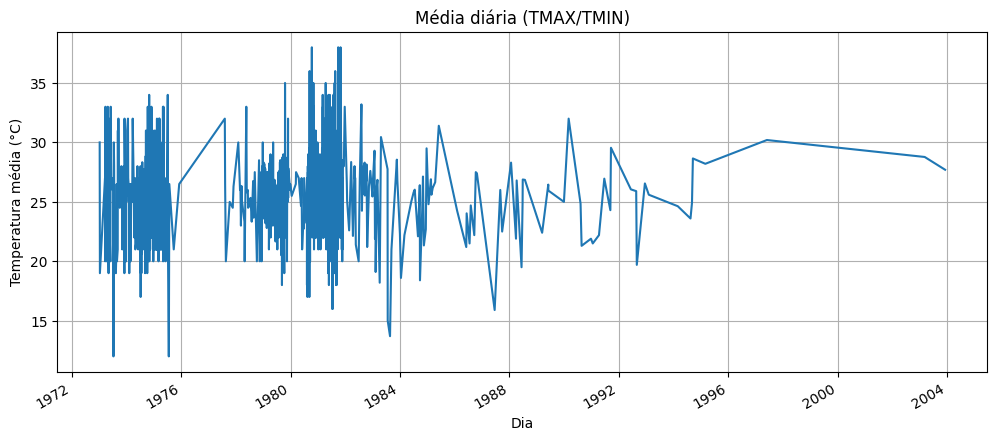

In [9]:
media_ano = data_filtrada.groupby(
    data_filtrada["date"].dt.year
)["temperature"].mean()

plt.figure(figsize=(12,5))
media_ano.plot()
plt.title("Média anual de temperatura (TMAX/TMIN)")
plt.xlabel("Ano")
plt.ylabel("Temperatura média (°C)")
plt.grid(True)
plt.show()


media_mes = data_filtrada.groupby([data_filtrada["date"].dt.year,
                                   data_filtrada["date"].dt.month])["temperature"].mean()

media_mes.index = pd.to_datetime([f"{ano}-{mes}-01" for ano, mes in media_mes.index])

plt.figure(figsize=(12,5))
media_mes.sort_index().plot()
plt.title("Média mensal de temperatura (TMAX/TMIN)")
plt.xlabel("Mes")
plt.ylabel("Temperatura média (°C)")
plt.grid(True)
plt.show()


media_dia = data_filtrada.groupby("date")["temperature"].mean()

plt.figure(figsize=(12,5))
media_dia.plot()
plt.title("Média diária (TMAX/TMIN)")
plt.xlabel("Dia")
plt.ylabel("Temperatura média (°C)")
plt.grid(True)
plt.show()

## Análise utilizando médias móveis
---
Realizamos a mesma análise porém utilizando de médias móveis e definindo escalas de tempo fixas para cada uma das situações.

A visualização dos dados ano a ano não gerou nenhuma complicação anteriormente, conseguimos enxergar com clareza a movimentação do gráfico ao longo da série.
Para a análise de mês em mês, decidimos realizar uma abordagem de trimestre em trimestre, aonde conseguimos uma melhora razoável na visualização dos dados.
Aonde temos uma melhora clara na vizualização é na análise dia a dia, aonde decidimos análisar os dados de três em três semanas.

É possivel notar que nas análises com médias móveis os dados se tornam melhor distribuidos.

C:\Users\felip\AppData\Local\Temp\ipykernel_17036\1736076626.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrada["temperature"] = data_filtrada["value"] * 0.1


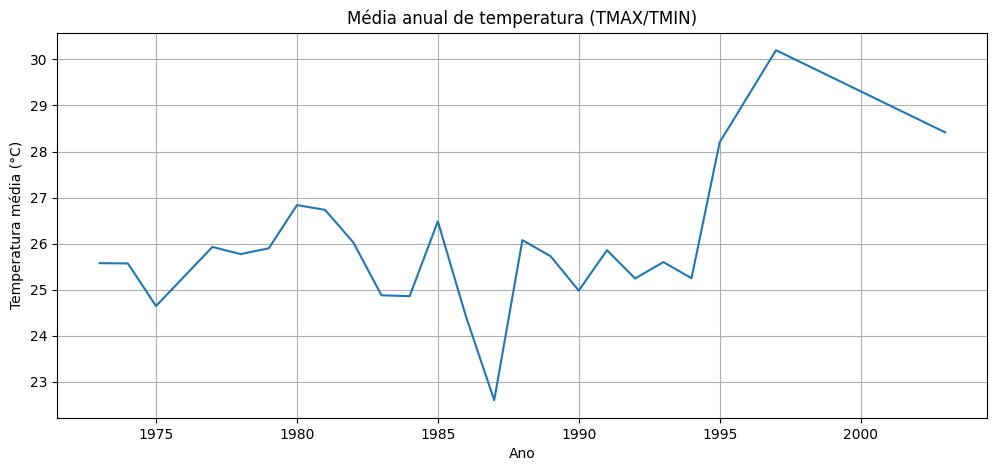

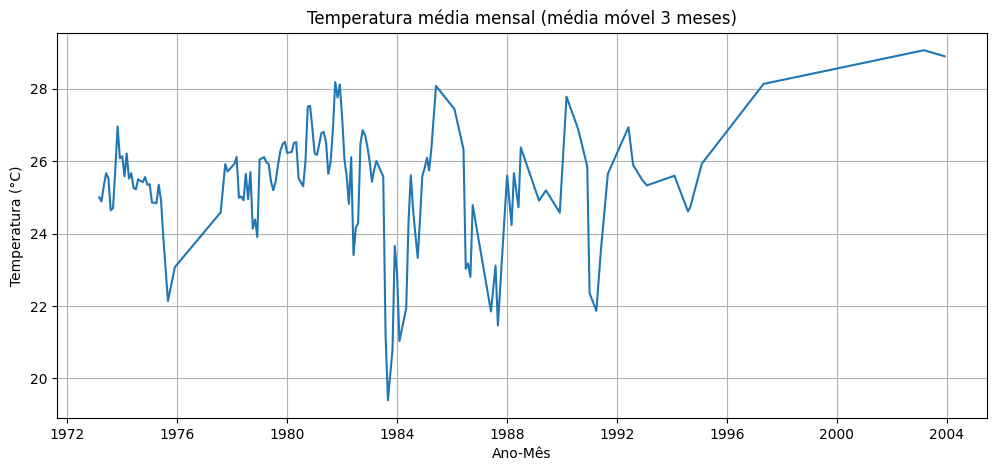

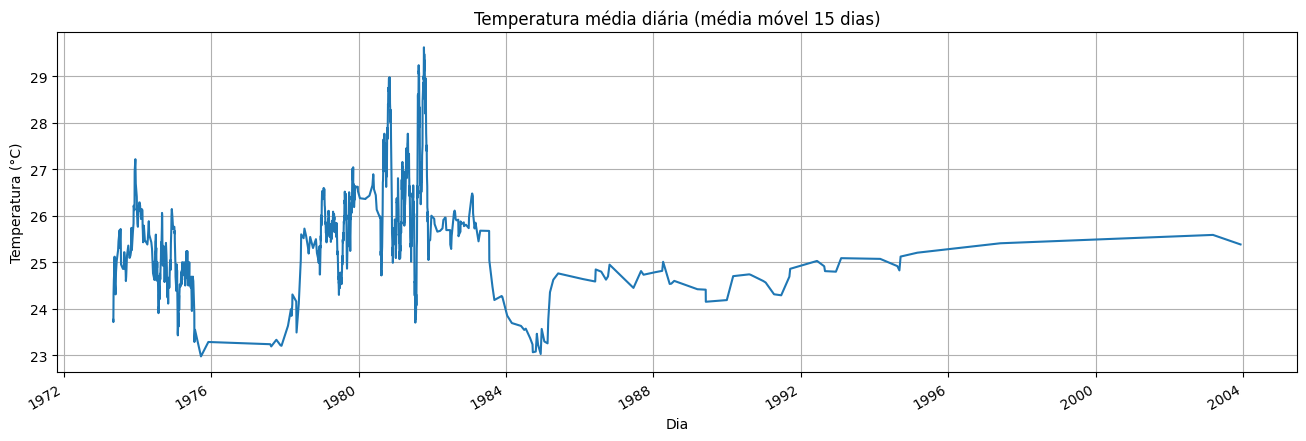

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

br_stations = [
    "BRM00083264",
    "BRM00083064",
    "BRM00082425",
    "BRM00082410",
    "BRM00082331"
]

station_data = data[data["station"].isin(br_stations)].copy()
data_filtrada = station_data[station_data["element"].isin(["TMAX","TMIN"])]

data_filtrada["temperature"] = data_filtrada["value"] * 0.1

media_ano = data_filtrada.groupby(
    data_filtrada["date"].dt.year
)["temperature"].mean()

plt.figure(figsize=(12,5))
media_ano.plot()
plt.title("Média anual de temperatura (TMAX/TMIN)")
plt.xlabel("Ano")
plt.ylabel("Temperatura média (°C)")
plt.grid(True)
plt.show()


# Criar colunas de ano e mês
df_mes = data_filtrada.copy()
df_mes["year"] = df_mes["date"].dt.year
df_mes["month"] = df_mes["date"].dt.month

# Média por ano-mês
media_mes = (
    df_mes
    .groupby(["year", "month"])["temperature"]
    .mean()
    .reset_index()
)

media_mes["date"] = pd.to_datetime(
    media_mes["year"].astype(str) + "-" +
    media_mes["month"].astype(str) + "-01"
)

media_mes = media_mes.sort_values("date")

media_mes["media_3m"] = media_mes["temperature"].rolling(window=3).mean()

plt.figure(figsize=(12,5))
plt.plot(media_mes["date"], media_mes["media_3m"])
plt.title("Temperatura média mensal (média móvel 3 meses)")
plt.xlabel("Ano-Mês")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()

media_dia = (
    data_filtrada
    .groupby("date")["temperature"]
    .mean()
    .sort_index()
)

media_dia_roll = media_dia.rolling(window=21).mean()

plt.figure(figsize=(16,5))
media_dia_roll.plot()
plt.title("Temperatura média diária (média móvel 15 dias)")
plt.xlabel("Dia")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()

## Análise de auto correlação entre as séries
---
Realizamos a análise de auto correlação entre as diferentes séries temporais, decidimos análisar a autocorrelação considerando até 21 periodos anteriores a váriavel.

Identificamos uma correlação significativa na série temporal que agrupa os dados em intervalos de três semanas Este pico de autocorrelação sugere a presença de um ciclo ou sazonalidade de três semanas nos dados.

     year  month  temperature       date   media_3m
0    1973      1    24.500000 1973-01-01        NaN
1    1973      2    24.000000 1973-02-01        NaN
2    1973      3    26.500000 1973-03-01  25.000000
3    1973      4    24.153846 1973-04-01  24.884615
4    1973      5    25.272727 1973-05-01  25.308858
..    ...    ...          ...        ...        ...
147  1994      9    25.985714 1994-09-01  24.739683
148  1995      2    28.200000 1995-02-01  25.928571
149  1997      5    30.200000 1997-05-01  28.128571
150  2003      3    28.775000 2003-03-01  29.058333
151  2003     12    27.700000 2003-12-01  28.891667

[152 rows x 5 columns]


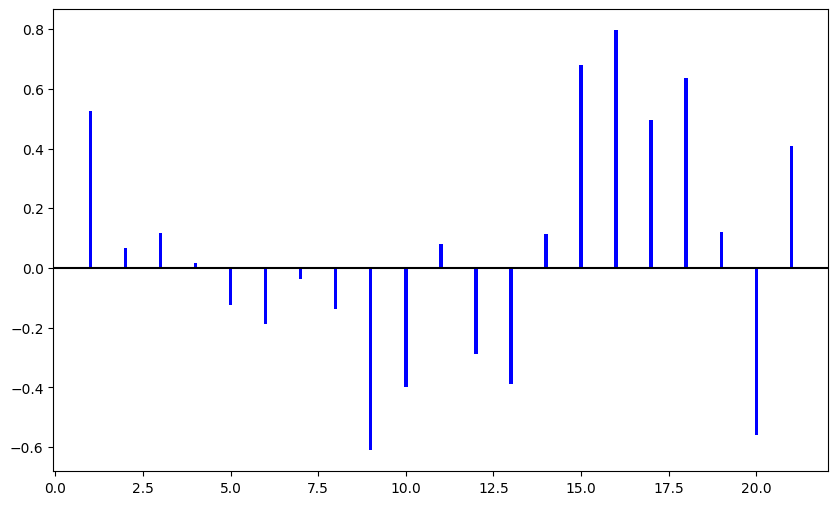

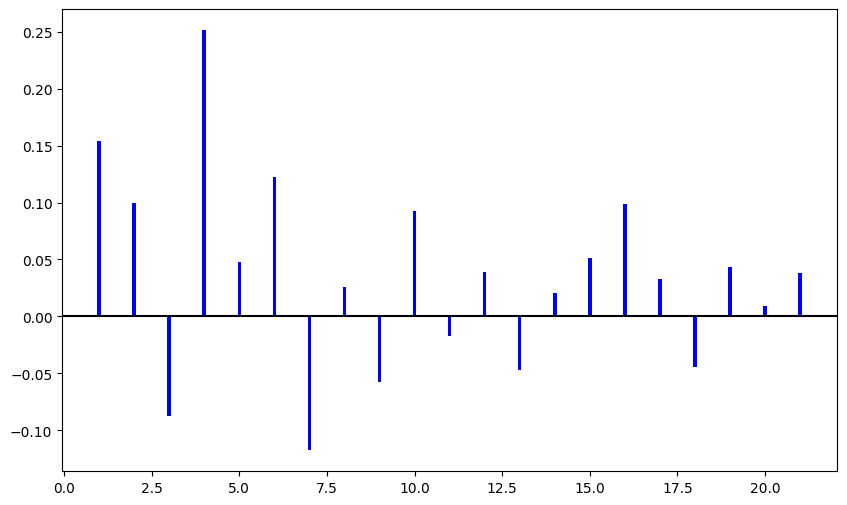

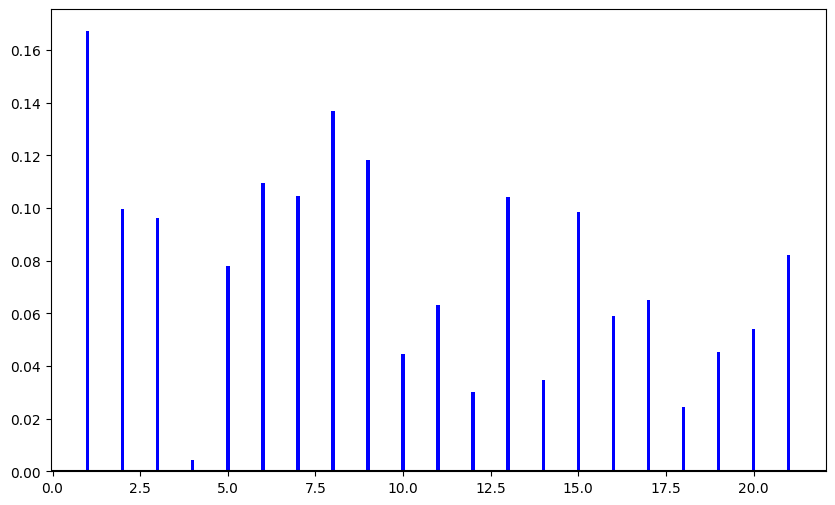

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

max_lags = 21

autocorrelacao_por_ano = {}
autocorrelacao_por_mes = {}
autocorrelacao_por_dia = {}

print(media_mes)

for lag in range(1, max_lags + 1):
    autocorrelacao_por_ano[lag] = media_ano.autocorr(lag=lag);
    autocorrelacao_por_mes[lag] = media_mes['temperature'].autocorr(lag=lag);
    autocorrelacao_por_dia[lag] = media_dia.autocorr(lag=lag);
    
df_ano = pd.DataFrame(
    autocorrelacao_por_ano.items(),
    columns=['lag', 'Autocorrelação']
)

df_mes = pd.DataFrame(
    autocorrelacao_por_mes.items(),
    columns=['lag', 'Autocorrelação']
)

df_dia = pd.DataFrame(
    autocorrelacao_por_dia.items(),
    columns=['lag', 'Autocorrelação']
)


#grafico

plt.figure(figsize=(10,6))

plt.bar(
    df_ano['lag'],
    df_ano['Autocorrelação'],
    width=0.1,
    color='blue'
)


plt.axhline(y=0, color='black', linestyle='-')

plt.figure(figsize=(10,6))

plt.bar(
    df_mes['lag'],
    df_mes['Autocorrelação'],
    width=0.1,
    color='blue'
)

plt.axhline(y=0, color='black', linestyle='-')

plt.figure(figsize=(10,6))

plt.bar(
    df_dia['lag'],
    df_dia['Autocorrelação'],
    width=0.1,
    color='blue'
)

plt.axhline(y=0, color='black', linestyle='-')

# Análise de Autocorrelação Parcial
----
Para simplificar a análise, utilizamos a biblioteca Statsmodels, que facilita o cálculo da PACF ao retornar diretamente os valores de autocorrelação parcial para cada série temporal. Definimos um lag máximo de 11 para garantir estabilidade estatística e evitar problemas associados ao tamanho reduzido de algumas séries.

A partir dos resultados, observamos que a correlação parcial não se diferencia significativamente da autocorrelação direta. Isso indica que os lags intermediários não estão introduzindo dependências adicionais entre os valores da série, ou seja, não há acúmulo de influência entre lags consecutivos.

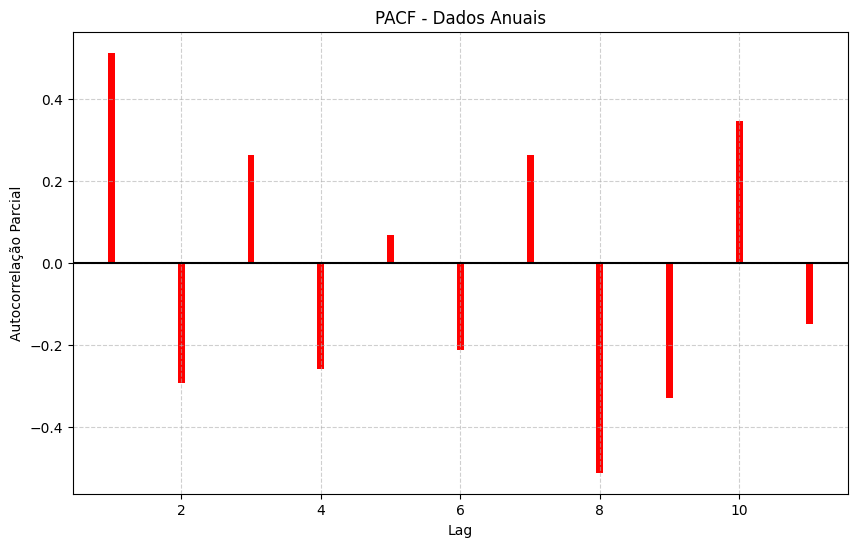

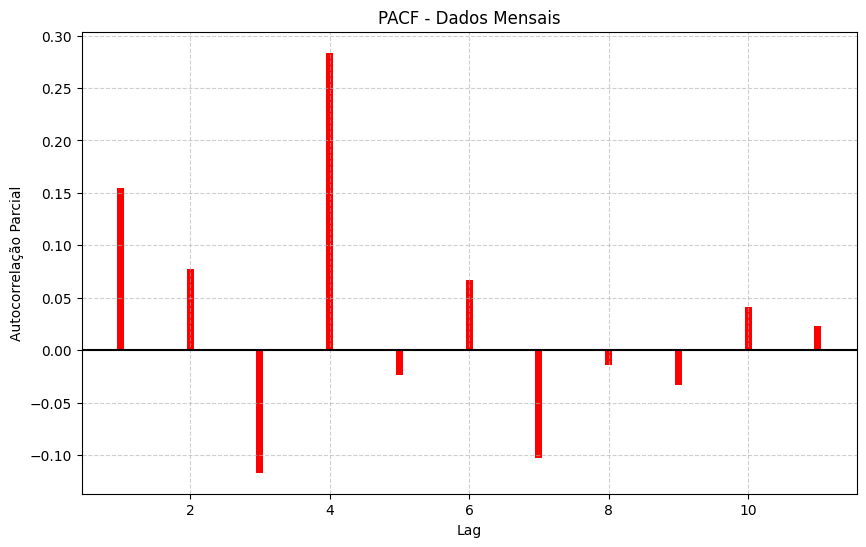

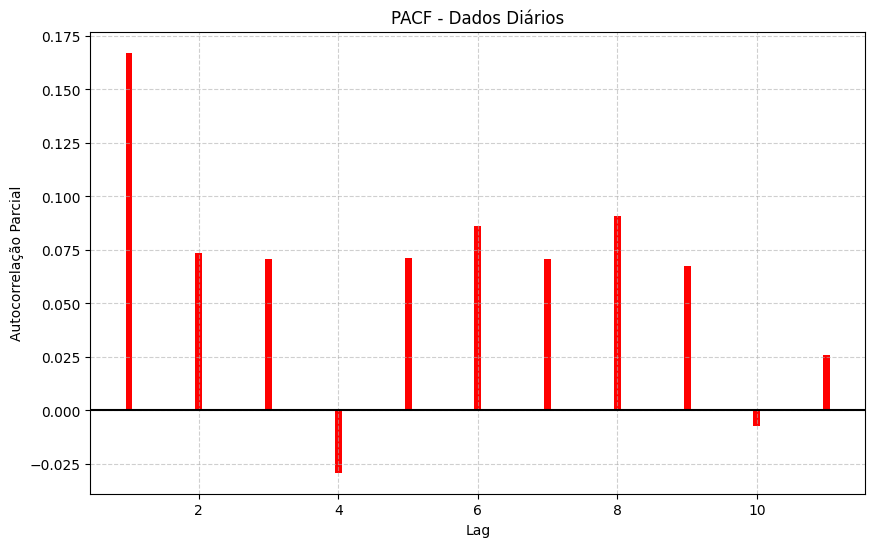

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Importação necessária para a PACF
from statsmodels.tsa.stattools import pacf # Pacf function

max_lags = 11

pacf_ano = pacf(media_ano, nlags=max_lags, method='yw')
pacf_mes = pacf(media_mes['temperature'], nlags=max_lags, method='yw')
pacf_dia = pacf(media_dia, nlags=max_lags, method='yw')

# Criando Os DataFrames
df_pacf_ano = pd.DataFrame({
    'lag': range(1, max_lags + 1),
    'PACF': pacf_ano[1:]
})

df_pacf_mes = pd.DataFrame({
    'lag': range(1, max_lags + 1),
    'PACF': pacf_mes[1:]
})

df_pacf_dia = pd.DataFrame({
    'lag': range(1, max_lags + 1),
    'PACF': pacf_dia[1:]
})

# --- PACF ---

# Gráfico PACF - Anual
plt.figure(figsize=(10, 6))
plt.bar(
    df_pacf_ano['lag'],
    df_pacf_ano['PACF'],
    width=0.1,
    color='red'
)
plt.axhline(y=0, color='black', linestyle='-')
plt.title('PACF - Dados Anuais')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação Parcial')
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico PACF - Mensal
plt.figure(figsize=(10, 6))
plt.bar(
    df_pacf_mes['lag'],
    df_pacf_mes['PACF'],
    width=0.1,
    color='red'
)
plt.axhline(y=0, color='black', linestyle='-')
plt.title('PACF - Dados Mensais')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação Parcial')
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico PACF - Diário
plt.figure(figsize=(10, 6))
plt.bar(
    df_pacf_dia['lag'],
    df_pacf_dia['PACF'],
    width=0.1,
    color='red'
)
plt.axhline(y=0, color='black', linestyle='-')
plt.title('PACF - Dados Diários')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação Parcial')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()